# Arima: Forecasting the Next 50 States

### Import Packages

In [1]:
import re
import pandas as pd
import pmdarima as pmd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import classification_report

### Prepare Data

In [2]:
# file names
## training
### subjects 1-30
train_subject_f = "UCI_HAR_Dataset/train/subject_train.txt"
### features
x_train_f = "UCI_HAR_Dataset/train/X_train.txt"
### classification 
y_train_f = "UCI_HAR_Dataset/train/y_train.txt"

## testing
### subjects 1-30
test_subject_f = "UCI_HAR_Dataset/test/subject_test.txt"
### features
x_test_f = "UCI_HAR_Dataset/test/X_test.txt"
### classification 
y_test_f = "UCI_HAR_Dataset/test/y_test.txt"

In [3]:
# training data frames
train_subject_df = pd.read_csv(train_subject_f, sep=' ', header=None)
x_train_df = pd.read_fwf(x_train_f, header=None)
y_train_df = pd.read_csv(y_train_f, sep=' ', header=None)

# testing dataframes
test_subject_df = pd.read_csv(test_subject_f, sep=' ', header=None)
x_test_df = pd.read_fwf(x_test_f, header=None)
y_test_df = pd.read_csv(y_test_f, sep=' ', header=None)

In [4]:
# combine subject information with training/testing data frames
x_train_df.insert(0, "Subject", train_subject_df)
y_train_df.insert(0, "Subject", train_subject_df)
x_test_df.insert(0, "Subject", test_subject_df)
y_test_df.insert(0, "Subject", test_subject_df)

In [5]:
# get list of features
# read the file 
features_file = open("UCI_HAR_Dataset/features.txt", "r") 
features_txt = features_file.read() 
  
# create list - one entry for each new line in file 
features_list = features_txt.split("\n") 
features_file.close() 

# remove last entry ' '
features_list.pop();

In [6]:
# clean the strings, add in first column (subject)
features_fixed = [re.split("\s", elem, 1)[1] for elem in features_list]
features_fixed.insert(0, "Subject")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6g/lht9tm8x1bz3sdrs0xk_d2m00000gn/T/ipykernel_38350/3421664769.py:2: SyntaxWarning: invalid escape sequence '\s'
  features_fixed = [re.split("\s", elem, 1)[1] for elem in features_list]


In [7]:
# remove fourier transform columns, and keep only mean measurements + subject column
indices = [((elem[0] != 'f') and (('mean' in elem) or ('ubject' in elem))) 
           for elem in features_fixed]
x_train_df = x_train_df[x_train_df.columns[indices]]
x_test_df = x_test_df[x_test_df.columns[indices]]

In [8]:
# combine testing and training data frames into one
y_all_data = pd.concat([y_train_df, y_test_df], axis=0)
x_all_data = pd.concat([x_train_df, x_test_df], axis=0)

### Building an Optimized Arima Model Per Subject

In [9]:
# function to build arima model with optimized p,d,q parameters
def arimamodel(timeseries_array, exog_vars):
    autoarima_model = pmd.auto_arima(timeseries_array,
                                     exog_vars,
                                     start_p=1, 
                                     start_q=1,
                                     test="adf",
                                     trace=True)
    return autoarima_model

In [10]:
# empty dataframe for predictions, original results, and AIC
predictions = pd.DataFrame()
testing = pd.DataFrame()
aic = pd.DataFrame()

In [11]:
# loop through each subject, create an optimized model, and capture the predictions and AIC
for i in range(1, len(y_all_data["Subject"].unique())+1):
    # get all entries for given subject
    y_all_data_i = y_all_data[y_all_data["Subject"] == i]
    x_all_data_i = x_all_data[x_all_data["Subject"] == i]
    # last 50 observations as forecasting, rest is training
    y_i_train = y_all_data_i[:(np.shape(y_all_data_i)[0]-50)]
    y_i_test = y_all_data_i[(np.shape(y_all_data_i)[0]-50):]
    x_i_train = x_all_data_i[:(np.shape(x_all_data_i)[0]-50)]
    x_i_test = x_all_data_i[(np.shape(x_all_data_i)[0]-50):]
    # record original state
    testing[str(i)] = y_i_test[0].values
    # testing arimax on all features, only on current subject
    arima_model = arimamodel(y_i_train[0], x_i_train.loc[:, x_i_train.columns != "Subject"])
    # record predicted state
    pred_i = arima_model.predict(len(y_i_test), x_i_test.loc[:, x_i_test.columns != "Subject"])
    pred_i = pred_i.reset_index(drop=True)
    predictions[str(i)] = pred_i
    # record AIC
    aic.at[i,"aic"] = arima_model.aic()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.094, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.959, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.010, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.428, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37.998, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38.889, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41.053, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.439, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.110, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=36.902, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36.022, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=39.009, Time=1.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.393 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22.610, Time=0.79 sec
 ARIM

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.264, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=512.640, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12.177, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=333.117, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=530.983, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14.129, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=179.085, Time=0.89 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.63 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.031 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=63.618, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=465.424, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67.395, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=306.283, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=473.346, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=52.442, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=56.459, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=71.224, Time=1.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=110.789, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=64.019, Time=0.94 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=61.887, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=58.314, Time=0.79 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 10.208 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11.779, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=526.818, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16.705, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=327.567, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=544.323, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5.398, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7.578, Time=0.83 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.003 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-101.929, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=531.389, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-92.868, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=338.383, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=529.418, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=188.097, Time=0.75 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-99.770, Time=0.93 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=233.799, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-94.193, Time=0.73 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-99.719, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-124.129, Time=0.72 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=337.120, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-56.209, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-98.102, Time=0.98 sec
 ARIMA(0,0,2)(0,0,0)[0]    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7.357, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5.283, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7.493, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7.975, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.300, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6.493, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5.720, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9.254, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8.629, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7.719, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8.777, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7.004, Time=0.97 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.418 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.342, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=444.138, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.226, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=281.584, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=456.877, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=54.097, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51.915, Time=0.77 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=58.642, Time=0.98 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=58.835, Time=1.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=55.307, Time=0.96 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=57.863, Time=0.97 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=56.846, Time=1.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53.227, Time=0.71 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 9.847 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63.123, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.489, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.270, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62.222, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.735, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.245 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=86.051, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=446.629, Time=0.58 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.008, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=296.443, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=536.285, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=89.992, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=96.122, Time=0.95 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=225.296, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=88.777, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=96.709, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=72.068, Time=0.75 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=335.559, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=81.206, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=76.448, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=75.713, Time=0.96 sec
 ARIMA(0,0,2)(0,0,0)[0]            

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-103.868, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-104.060, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.401, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-105.127, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-105.764, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.950 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-26.537, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=439.792, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-28.899, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=240.246, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=532.649, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-26.802, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-19.946, Time=0.80 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.52 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.864 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9.327, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12.152, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.261, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.309, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.688, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.105 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.762, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=501.509, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.097, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=284.842, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=506.512, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=36.388, Time=0.88 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=35.652, Time=1.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=170.108, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32.898, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=34.600, Time=0.96 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=35.943, Time=0.75 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.372 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24.551, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-27.722, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.499, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.529, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29.022, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.229 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-86.059, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=532.399, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-79.008, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=347.333, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=530.645, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-73.755, Time=0.84 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-103.214, Time=1.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=220.803, Time=1.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-100.851, Time=1.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-100.798, Time=1.39 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=142.109, Time=1.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-105.565, Time=1.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-105.609, Time=1.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-75.088, Time=1.17 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-83.350, Time=1.52 sec
 ARIMA(3,0,4)(0,0,0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.060, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=441.757, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5.576, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=234.906, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=457.877, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6.729, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=11.162, Time=1.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=173.773, Time=1.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.431, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10.170, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1.369, Time=0.74 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=232.214, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2.207, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3.288, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-0.523, Time=0.97 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=153.394, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=558.658, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=156.578, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=358.289, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=615.771, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=186.260, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=160.314, Time=1.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=275.488, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=154.074, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=171.408, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=167.478, Time=0.72 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.567 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-19.984, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=525.149, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16.717, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=291.034, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=585.121, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12.900, Time=0.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-15.041, Time=0.98 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=176.448, Time=1.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-15.404, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6.912, Time=1.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2.184, Time=0.78 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.430 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-196.516, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=348.502, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-173.917, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=101.831, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=357.456, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-190.254, Time=0.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-193.261, Time=1.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-11.875, Time=1.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-187.379, Time=0.86 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-189.791, Time=1.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-182.495, Time=1.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.460 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10.713, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=255.859, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13.355, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=136.106, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=342.125, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11.031, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=12.826, Time=1.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=98.962, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12.364, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10.526, Time=0.93 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6.693, Time=1.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13.268, Time=1.04 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=10.724, Time=1.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8.850, Time=1.52 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=11.130, Time=1.34 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : A

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97.209, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=570.982, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=99.509, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=365.387, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=619.450, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=98.563, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=96.596, Time=1.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=284.202, Time=1.00 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=88.773, Time=1.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=169.295, Time=1.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=96.794, Time=1.45 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=92.377, Time=1.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=90.225, Time=1.12 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=107.632, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=93.625, Time=1.15 sec

Best model:  ARIMA(2,0,2)(0,0,0)[

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.424, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.850, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-97.062, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.563, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.844, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-95.360, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-92.970, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-99.293, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-97.504, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-97.489, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.653, Time=0.92 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-95.298, Time=0.90 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.958 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.771, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.822, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.772, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.762, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.879, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=39.691, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41.759, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35.804, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.759, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=37.753, Time=1.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35.789, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=37.695, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39.649, Time=1.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 11.166 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37.423, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=680.780, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.955, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=426.523, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=690.457, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=42.046, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=40.430, Time=0.99 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=275.140, Time=1.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38.536, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=42.629, Time=1.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=38.051, Time=0.85 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.071 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-48.936, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=485.793, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-61.297, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=274.243, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=494.795, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-58.878, Time=0.80 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-58.023, Time=0.57 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.422 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.779, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=600.557, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.494, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=300.827, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=684.704, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=34.948, Time=0.92 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=30.246, Time=1.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=177.485, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=36.429, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18.718, Time=1.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=34.329, Time=1.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=35.689, Time=1.29 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=30.896, Time=1.34 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=36.057, Time=1.23 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=32.304, Time=1.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-215.591, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=151.400, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-212.078, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2.529, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=245.608, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-192.062, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-189.232, Time=1.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-71.136, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-221.356, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-198.139, Time=1.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-208.228, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-249.544, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-248.659, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-242.228, Time=0.95 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-237.684, Time=0.81 sec
 ARIMA(1,0,1)(0,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7.554, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=469.952, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9.333, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=231.419, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=470.995, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7.203, Time=0.89 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5.085, Time=0.88 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1.520, Time=1.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1.149, Time=1.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3.973, Time=2.26 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-1.597, Time=1.43 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2.886, Time=1.18 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=0.501, Time=2.18 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3.246, Time=1.48 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-0.173, Time=1.18 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=2.43

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Results: Visualizations

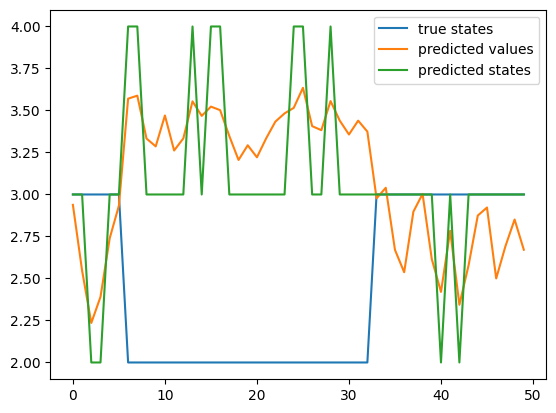

In [12]:
# view plot of an individual subject's results
s = 1
plt.plot(testing.index, testing[str(s)].astype('int'), label="true states")
plt.plot(testing.index, predictions[str(s)], label="predicted values")
plt.plot(testing.index, round(predictions[str(s)]).astype('int'), label="predicted states")
plt.legend()
plt.savefig("arima_50_" +str(s)+".pdf", format="pdf")

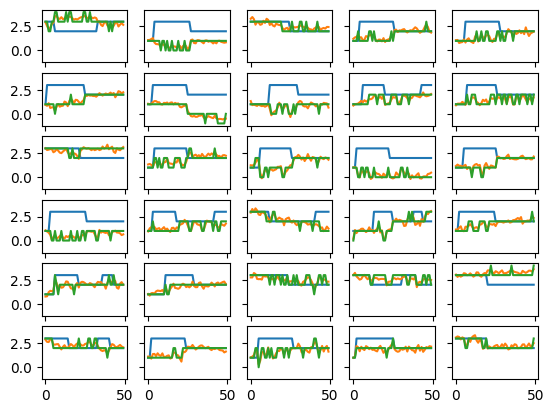

In [13]:
# view plots of results for all subjects
fig, axs = plt.subplots(6, 5, sharex=True, sharey=True)

# initialize subject 1
subject = 1
# plot each set of results
for row in range(0,6):
    for col in range(0,5):
        axs[row, col].plot(testing.index, testing[str(subject)].astype('int'), label="true states")
        axs[row, col].plot(testing.index, predictions[str(subject)], label="predicted values")
        axs[row, col].plot(testing.index, round(predictions[str(subject)]).astype('int'), label="predicted states")
        subject = subject + 1

# hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.savefig("arima_50.pdf", format="pdf", bbox_inches="tight")

### Results: Accuracy

In [14]:
# Accuracy
# create empty dataframe to store accuracy
accuracy = pd.DataFrame()

# get accuracy using the classification report from sklearn
for i in range(1,31):
    rep_i = classification_report(testing[str(i)].astype('string'), 
                          round(predictions[str(i)]).astype('int').astype('str'))
    acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
    accuracy.at[i,"accuracy"] = acc_i

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6g/lht9tm8x1bz3sdrs0xk_d2m00000gn/T/ipykernel_38350/707666640.py:9: SyntaxWarning: invalid escape sequence '\d'
  acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Py

In [15]:
accuracy.mean()

accuracy    0.467333
dtype: float64

In [16]:
accuracy.describe()

,accuracy
count,30.000000
mean,0.467333
std,0.209201
min,0.040000
25%,0.400000
50%,0.510000
75%,0.575000
max,0.900000


### Results: AIC

In [17]:
aic.mean()

aic   -10.248452
dtype: float64

In [18]:
aic.describe()

,aic
count,30.000000
mean,-10.248452
std,85.137414
min,-249.543903
25%,-28.991129
50%,3.084768
75%,37.014588
max,153.394096
